In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import celltypist
import gc
import anndata
from celltypist import models
import h5py
import scipy.sparse as scs
from multiprocessing import Pool
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
from adjustText import adjust_text
import scanpy.external as sce
import multiprocessing
import copy

/home/workspace/Aux_Envir/Python_BRI_Figures/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/workspace/Aux_Envir/Python_BRI_Figures/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/workspace/Aux_Envir/Python_BRI_Figures/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/workspace/Aux_Envir/Python_BRI_Figures/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/workspace/Aux_Envir/Python_BRI_Figures/lib/python3.11/site-p

In [2]:
meta_data=pd.read_csv('/home/workspace/private/bri_figure_all_files_test/jupyter/BRI_Figures_Final_V2/Figure5/03_TEAseq_PenSenior/meta_data_GEO.csv')


In [3]:
adata=sc.read_h5ad("/home/workspace/private/bri_figure_all_files_test/jupyter/BRI_Figures_Final_V2/Figure5/03_TEAseq_PenSenior/TEA_scRNA.h5ad")
adata=adata.raw.to_adata()

In [4]:
adata_subset=adata[adata.obs['AIFI_L3'].isin(['GZMK+ CD27+ EM CD8 T cell',
                                                               'CM CD8 T cell',
                                                               'Core naive CD8 T cell',
                                                               'KLRF1+ GZMB+ CD27- EM CD8 T cell',
                                                               'KLRF1- GZMB+ CD27- EM CD8 T cell',
                                                              'GZMK- CD27+ EM CD8 T cell'])]

In [5]:
adata_subset.raw=adata_subset
sc.pp.normalize_total(adata_subset, 
                      target_sum=1e4)
sc.pp.log1p(adata_subset)

In [6]:
adata_subset

AnnData object with n_obs × n_vars = 97492 × 36601
    obs: 'barcodes', 'adt_qc_flag', 'adt_umis', 'batch_id', 'cell_name', 'chip_id', 'hto_barcode', 'hto_category', 'n_genes', 'n_mito_umis', 'n_reads', 'n_umis', 'original_barcodes', 'pbmc_sample_id', 'pool_id', 'rna_cell_uuid', 'seurat_pbmc_type', 'seurat_pbmc_type_score', 'umap_1', 'umap_2', 'well_id', 'predicted_doublet', 'doublet_score', 'AIFI_L1', 'AIFI_L2', 'AIFI_L3', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    obsp: 'connectivities', 'distances'

In [7]:
sc.pp.highly_variable_genes(adata_subset)
adata_subset = adata_subset[:, adata_subset.var_names[adata_subset.var['highly_variable']]]

In [8]:
%%time
sc.pp.scale(adata_subset)
sc.tl.pca(adata_subset,
          svd_solver='arpack')
sce.pp.harmony_integrate(adata_subset,
                         'batch_id',
                         max_iter_harmony = 20)
sc.pp.neighbors(adata_subset,
                n_neighbors=50,
                use_rep='X_pca_harmony',
                n_pcs=30)

2025-02-19 09:12:18,574 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
Computing initial centroids with sklearn.KMeans...
2025-02-19 09:12:23,611 - harmonypy - INFO - sklearn.KMeans initialization complete.
sklearn.KMeans initialization complete.
2025-02-19 09:12:23,913 - harmonypy - INFO - Iteration 1 of 20
Iteration 1 of 20
2025-02-19 09:12:41,571 - harmonypy - INFO - Iteration 2 of 20
Iteration 2 of 20
2025-02-19 09:12:59,525 - harmonypy - INFO - Iteration 3 of 20
Iteration 3 of 20
2025-02-19 09:13:17,214 - harmonypy - INFO - Converged after 3 iterations
Converged after 3 iterations
/home/workspace/Aux_Envir/Python_BRI_Figures/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CPU times: user 22min 15s, sys: 14.2 s, total: 22min 29s
Wall time: 2min 29s


In [9]:
%%time
sc.tl.umap(adata_subset,
           min_dist=0.45,
           random_state=0)

CPU times: user 4min 20s, sys: 292 ms, total: 4min 20s
Wall time: 1min 13s


In [10]:
df=adata_subset.obs
df=df.merge(meta_data, on='pbmc_sample_id',how='left')

In [11]:
df.index=df['barcodes'].tolist()
adata_subset.obs=df

In [12]:
adata_subset.obs['cohort'] = adata_subset.obs['subject_id.ch1'].apply(lambda x: 'UP1' if 'UP' in x else 'BR2')

In [13]:
adata_subset=adata_subset.raw.to_adata()
sc.pp.normalize_total(adata_subset, 
                      target_sum=1e4)
sc.pp.log1p(adata_subset)
adata_subset.raw=adata_subset


In [14]:
sc.tl.leiden(adata_subset,
             key_added="leiden")

In [15]:
sc.tl.rank_genes_groups(adata_subset, "leiden", method="t-test")


... storing 'pbmc_sample_id' as categorical
... storing 'GEO_Accession' as categorical
... storing 'Batch' as categorical
... storing 'combined_sample_id' as categorical
... storing 'cell.type.ch1' as categorical
... storing 'race.ch1' as categorical
... storing 'Sex.ch1' as categorical
... storing 'subject_id.ch1' as categorical
... storing 'cohort' as categorical


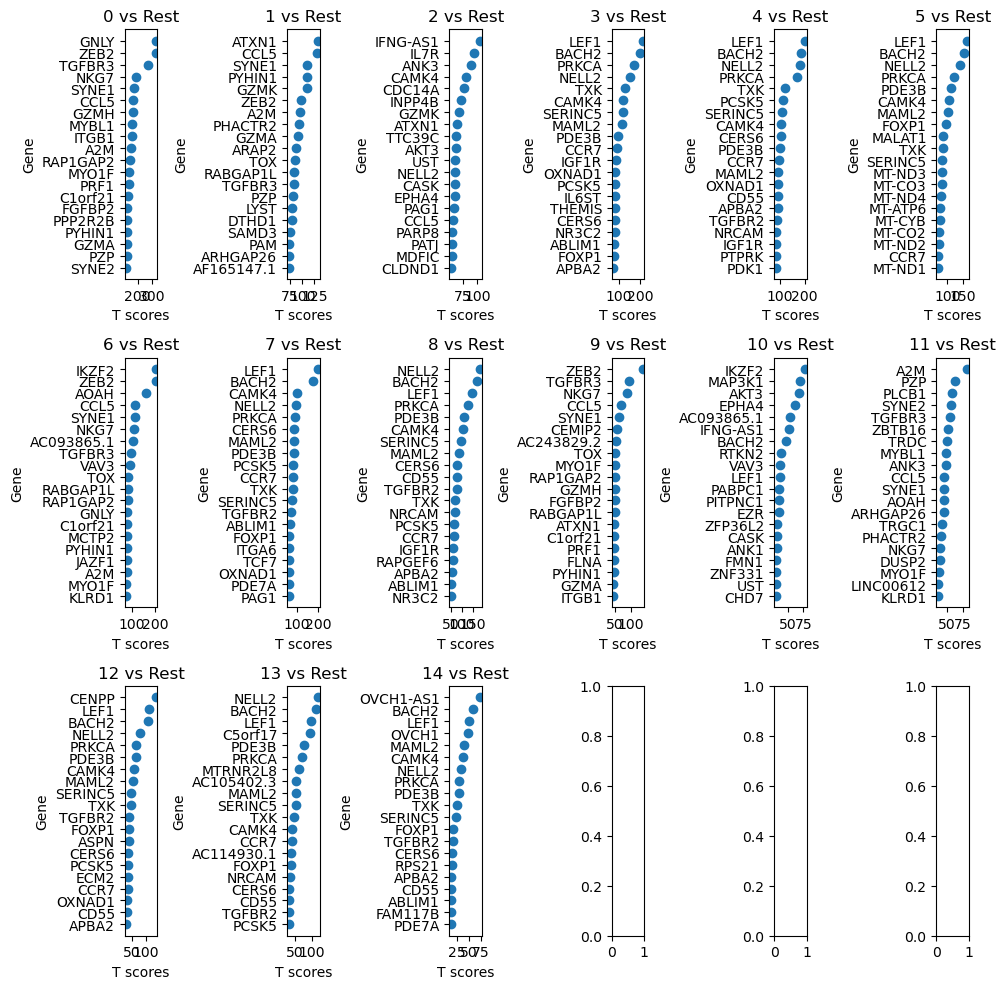

In [16]:
DEG_df=sc.get.rank_genes_groups_df(adata_subset,group=None)
DEG_df=DEG_df.groupby('group').head(20).reset_index(drop=True)
import matplotlib.pyplot as plt

groups = DEG_df.groupby('group')

fig, axs = plt.subplots(3, 6, figsize=(10, 10), squeeze=False)

# Loop through each group and create a scatter plot in the corresponding subplot
for i, (name, group) in enumerate(groups):
    row, col = i // 6, i % 6
    axs[row, col].scatter(group['scores'], group['names'])
    axs[row, col].invert_yaxis()
    axs[row, col].set_title(str(name)+" vs Rest")
    axs[row, col].set_xlabel('T scores')
    axs[row, col].set_ylabel('Gene')
fig.tight_layout()

In [17]:
adata_subset

AnnData object with n_obs × n_vars = 97492 × 36601
    obs: 'barcodes', 'adt_qc_flag', 'adt_umis', 'batch_id', 'cell_name', 'chip_id', 'hto_barcode', 'hto_category', 'n_genes', 'n_mito_umis', 'n_reads', 'n_umis', 'original_barcodes', 'pbmc_sample_id', 'pool_id', 'rna_cell_uuid', 'seurat_pbmc_type', 'seurat_pbmc_type_score', 'umap_1', 'umap_2', 'well_id', 'predicted_doublet', 'doublet_score', 'AIFI_L1', 'AIFI_L2', 'AIFI_L3', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'Unnamed: 0', 'GEO_Accession', 'Batch', 'combined_sample_id', 'age.ch1', 'birth.year.ch1', 'cell.type.ch1', 'library.type.ch1', 'race.ch1', 'Sex.ch1', 'subject_id.ch1', 'cohort', 'leiden'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'neighbors',

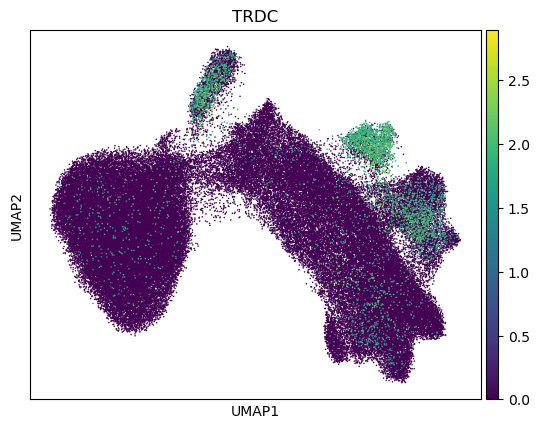

In [18]:
sc.pl.umap(adata_subset, color=["TRDC"],size=5,use_raw=False,ncols=2)

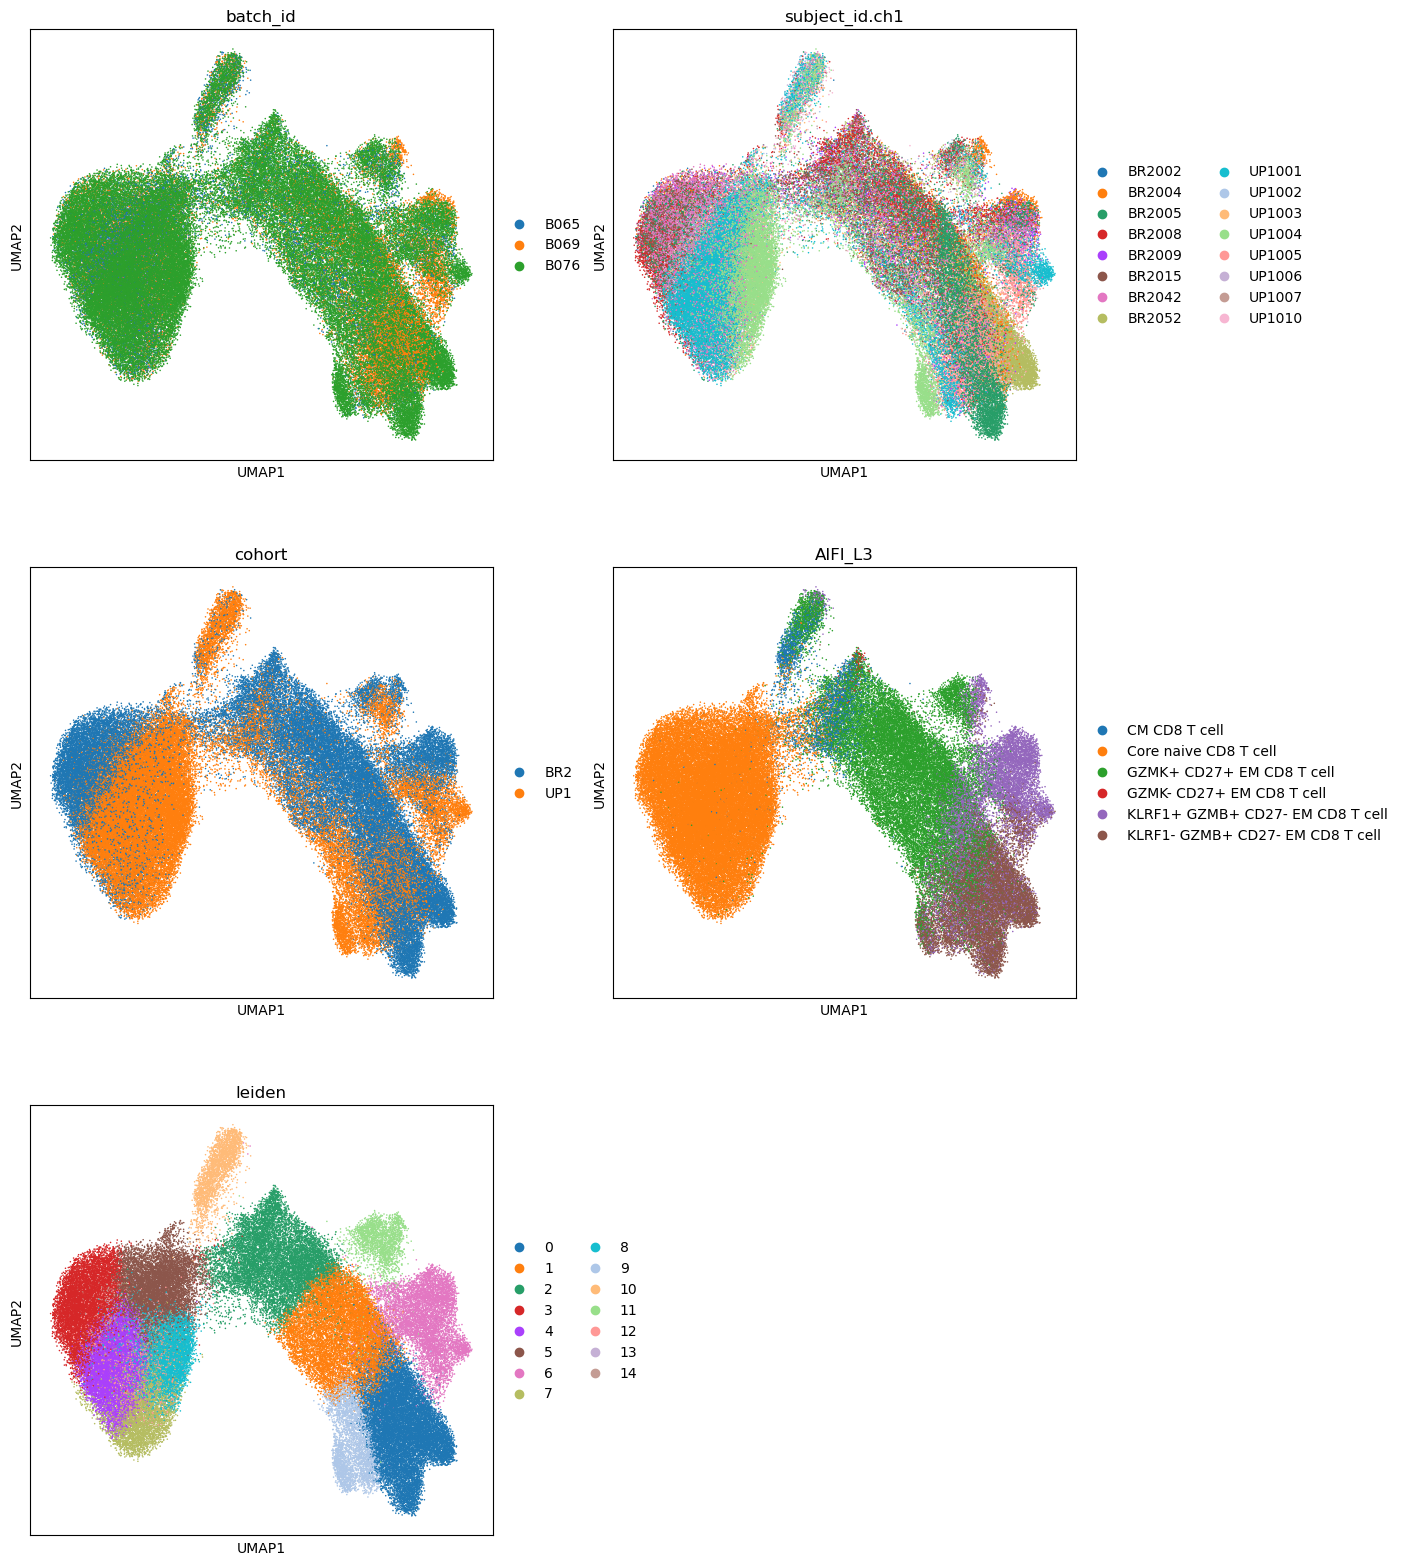

In [19]:
plt.rcParams['figure.figsize'] = [6, 6]

sc.pl.umap(adata_subset, color=["batch_id", 'subject_id.ch1',"cohort",'AIFI_L3',"leiden"],size=5,use_raw=False,ncols=2)

In [20]:
adata_subset=adata_subset[~adata_subset.obs["leiden"].isin(["10","11"])]

In [21]:
adata_subset=adata_subset.raw.to_adata()
sc.pp.normalize_total(adata_subset, 
                      target_sum=1e4)
sc.pp.log1p(adata_subset)

In [22]:
adata_subset.raw=adata_subset


In [23]:
sc.pp.highly_variable_genes(adata_subset)
adata_subset = adata_subset[:, adata_subset.var_names[adata_subset.var['highly_variable']]]
sc.pp.scale(adata_subset)
sc.tl.pca(adata_subset,
          svd_solver='arpack')
sce.pp.harmony_integrate(adata_subset,
                         'batch_id',
                         max_iter_harmony = 20)
sc.pp.neighbors(adata_subset,
                n_neighbors=50,
                use_rep='X_pca_harmony',
                n_pcs=30)

2025-02-19 09:17:57,607 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
Computing initial centroids with sklearn.KMeans...
2025-02-19 09:18:02,408 - harmonypy - INFO - sklearn.KMeans initialization complete.
sklearn.KMeans initialization complete.
2025-02-19 09:18:02,704 - harmonypy - INFO - Iteration 1 of 20
Iteration 1 of 20
2025-02-19 09:18:20,013 - harmonypy - INFO - Iteration 2 of 20
Iteration 2 of 20
2025-02-19 09:18:37,551 - harmonypy - INFO - Iteration 3 of 20
Iteration 3 of 20
2025-02-19 09:18:54,121 - harmonypy - INFO - Converged after 3 iterations
Converged after 3 iterations


In [24]:
sc.tl.umap(adata_subset,
           min_dist=0.45,
           random_state=0)


In [25]:
sc.tl.leiden(adata_subset,
             key_added="leiden")

IOStream.flush timed out


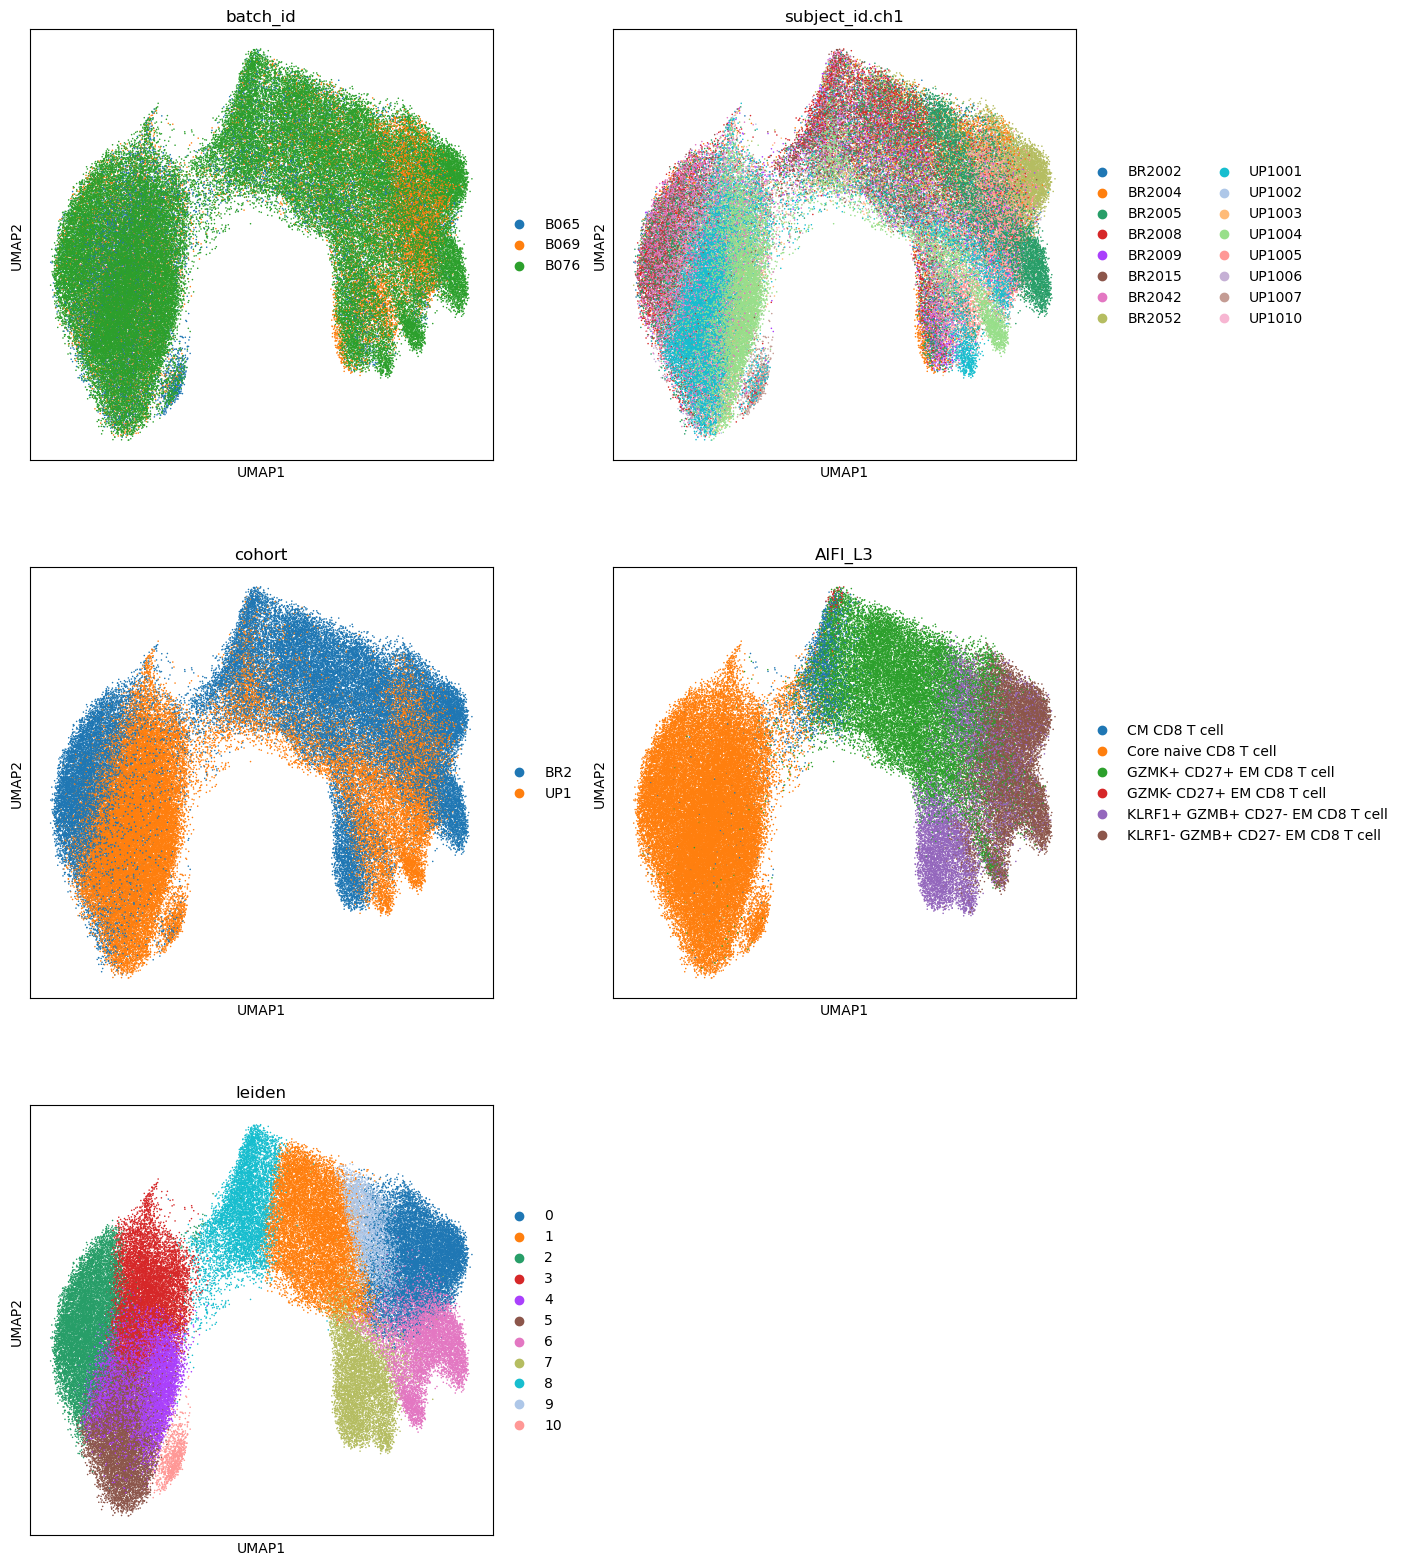

In [26]:
plt.rcParams['figure.figsize'] = [6, 6]

sc.pl.umap(adata_subset, color=["batch_id", 'subject_id.ch1',"cohort",'AIFI_L3',"leiden"],size=5,use_raw=False,ncols=2)

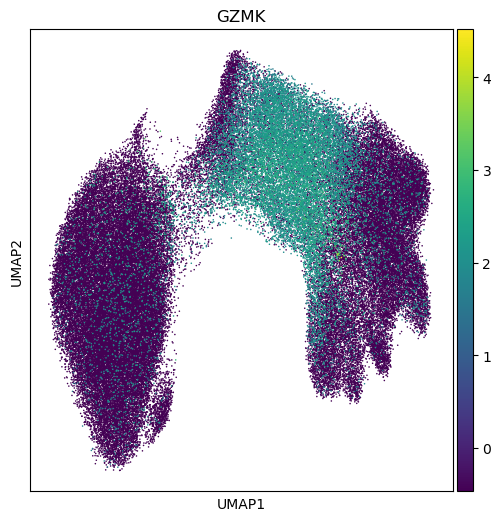

In [27]:
plt.rcParams['figure.figsize'] = [6, 6]

sc.pl.umap(adata_subset, color=["GZMK"],size=5,use_raw=False,ncols=2)

In [58]:
umap=pd.DataFrame(adata_subset.obsm['X_umap'])

In [60]:
umap[0].tolist()

[7.143134117126465,
 11.944886207580566,
 -0.266364723443985,
 -2.4370620250701904,
 -2.877058982849121,
 7.83878755569458,
 12.128251075744629,
 11.638306617736816,
 9.562314987182617,
 9.323677062988281,
 5.743180274963379,
 1.1120076179504395,
 4.914011478424072,
 5.702954292297363,
 10.261220932006836,
 13.295295715332031,
 6.771454334259033,
 9.840224266052246,
 7.620092868804932,
 0.4746098816394806,
 -0.47643381357192993,
 -1.8415907621383667,
 6.153270244598389,
 0.8779615163803101,
 9.833072662353516,
 11.055219650268555,
 9.30417537689209,
 12.972753524780273,
 8.611369132995605,
 7.972460746765137,
 10.033127784729004,
 9.924582481384277,
 7.900850772857666,
 10.67283821105957,
 1.5673972368240356,
 9.530065536499023,
 9.178787231445312,
 5.557437419891357,
 9.210380554199219,
 9.19127082824707,
 7.165315628051758,
 5.852558612823486,
 13.147963523864746,
 6.1106462478637695,
 10.35682487487793,
 11.17411994934082,
 5.742196083068848,
 8.833675384521484,
 7.142165660858154,


In [61]:
adata_subset.obs["UMAP_1"]=umap[0].tolist()
adata_subset.obs["UMAP_2"]=umap[1].tolist()

In [62]:
adata_subset.obs.to_csv("scRNA_obs.csv")